# Análise de Resultados Geral
---
Avaliação sistemática dos resultados obtidos considerando a hipóptese de adoção de gráfico de recorrência para o problema de classificação de séries temporais no contexto de NILM. 

Foram avaliadas 3 métodos:

1. Atributos RQA + classificadores rasos (abordagens tradicionais Machine Learning);
2. Atributos extraídos via Deep Learning + classificadores rasos;
3. Classificação via Deep Learning (abordagem CNN end-to-end).

# Configurações e Dados

In [4]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *
from glob import glob

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "24") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)

In [8]:
datasets = []

# Resultados abordagem 1 (RQA + Machine Learning)
for arquivo in glob(os.path.join(caminho_dados, "22/df_resultados_*.xlsx")):
    df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
    df_["method"] = "RQA+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
    datasets.append(df_)

# Resultados abordagem 2 (RP DeepLearning Automatic Feature Extraction + Machine Learning)
for arquivo in glob(os.path.join(caminho_dados, "23/df_resultados_*.xlsx")):
    df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
    df_["method"] = "DLAFE+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
    datasets.append(df_)

# Resultados abordagem 3 (end-to-end CNN)
df_ = pd.read_excel(
    os.path.join(caminho_dados, "20/residencia_3/resultados_baseline_cv.xlsx"),
    names=["appliance","fold","test","acc","f1","auc","method"], engine="openpyxl"
)
df_ = df_[df_["test"]==1] # Selecionando apenas 1 rodada de teste
del df_["test"]
df_["method"] = "RP+CNN"
datasets.append(df_)

# Dataframe com todos resultados
df = pd.concat(datasets)

# Análises

## Estatísticas gerais

In [34]:
print("* Análise por metodologia:")
df_analise_metodo = df.groupby(["method","base"]).agg({
    "acc": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("method")
display(df_analise_metodo)
df_analise_metodo.to_excel(os.path.join(caminho_dados_notebook, "df_analise_metodo.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df.groupby(["appliance","method","base"]).agg({
    "acc": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).sort_values(["appliance",('f1','mean')],ascending=[True,False])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise_aparelho.xlsx"))

* Análise por metodologia:


base       acc                                      f1  \
                           mean       std       max       min      mean   
method                                                                    
DLAFE+XGBOOST   teste  1.000000  0.000000  1.000000  1.000000  1.000000   
DLAFE+MLP       teste  0.992610  0.009104  1.000000  0.978102  0.881158   
DLAFE+SVM       teste  0.983314  0.009541  0.993865  0.968137  0.763175   
DLAFE+SVM      treino  0.976712  0.017036  1.000000  0.937500  0.761836   
DLAFE+XGBOOST  treino  0.972298  0.022801  1.000000  0.888889  0.754227   
DLAFE+MLP      treino  0.965596  0.030885  1.000000  0.875000  0.740785   
RQA+XGBOOST    treino  0.970681  0.026105  1.000000  0.893617  0.694913   
RQA+XGBOOST     teste  0.957072  0.018284  0.981752  0.932515  0.584950   
RQA+MLP        treino  0.968745  0.018680  1.000000  0.937500  0.583854   
RQA+SVM        treino  0.968745  0.018680  1.000000  0.937500  0.583854   
RQA+MLP         teste  0.957065  0.017917  0.981752  0.938650  0.488997   
RQA+SVM         teste  0.957065  0.017917  0.981752  0.938650  0.488997   

                                                  auc                      \
                    std       max       min      mean       std       max   
method                                                                      
DLAFE+XGBOOST  0.000000  1.000000  1.000000  1.000000  0.000000  1.000000   
DLAFE+MLP      0.217398  1.000000  0.494465  0.868441  0.210701  1.000000   
DLAFE+SVM      0.246814  0.972056  0.491905  0.742139  0.223176  0.950000   
DLAFE+SVM      0.214826  1.000000  0.483871  0.694653  0.197203  1.000000   
DLAFE+XGBOOST  0.207444  1.000000  0.470588  0.693422  0.196615  1.000000   
DLAFE+MLP      0.207886  1.000000  0.467532  0.680764  0.187977  1.000000   
RQA+XGBOOST    0.215395  1.000000  0.472527  0.596003  0.156165  1.000000   
RQA+XGBOOST    0.071581  0.687007  0.495396  0.562820  0.053958  0.640269   
RQA+MLP        0.199462  1.000000  0.483871  0.500000  0.000000  0.500000   
RQA+SVM        0.199462  1.000000  0.483871  0.500000  0.000000  0.500000   
RQA+MLP        0.004665  0.495396  0.484177  0.500000  0.000000  0.500000   
RQA+SVM        0.004665  0.495396  0.484177  0.500000  0.000000  0.500000   

                         
                    min  
method                   
DLAFE+XGBOOST  1.000000  
DLAFE+MLP      0.498141  
DLAFE+SVM      0.500000  
DLAFE+SVM      0.500000  
DLAFE+XGBOOST  0.461538  
DLAFE+MLP      0.461538  
RQA+XGBOOST    0.477778  
RQA+XGBOOST    0.500000  
RQA+MLP        0.500000  
RQA+SVM        0.500000  
RQA+MLP        0.500000  
RQA+SVM        0.500000


* Análise por aparelho/metodologia:


acc                      \
                                            mean       std       max   
appliance         method        base                                   
dish_washer - 9   DLAFE+XGBOOST teste   1.000000       NaN  1.000000   
                  DLAFE+MLP     teste   0.997549       NaN  0.997549   
                  RQA+XGBOOST   teste   0.965686       NaN  0.965686   
                  DLAFE+MLP     treino  0.960854  0.034818  1.000000   
                  RQA+MLP       treino  0.974944  0.008725  0.983333   
                  RQA+SVM       treino  0.974944  0.008725  0.983333   
                  RQA+XGBOOST   treino  0.971582  0.011246  0.983333   
                  DLAFE+SVM     teste   0.968137       NaN  0.968137   
                  RQA+MLP       teste   0.968137       NaN  0.968137   
                  RQA+SVM       teste   0.968137       NaN  0.968137   
                  DLAFE+SVM     treino  0.968171  0.011700  0.975610   
                  DLAFE+XGBOOST treino  0.968171  0.011700  0.975610   
fridge - 7        DLAFE+XGBOOST teste   1.000000       NaN  1.000000   
                  RQA+MLP       treino  1.000000  0.000000  1.000000   
                  RQA+SVM       treino  1.000000  0.000000  1.000000   
                  RQA+XGBOOST   treino  1.000000  0.000000  1.000000   
                  DLAFE+SVM     treino  0.982011  0.018967  1.000000   
                  DLAFE+MLP     treino  0.974603  0.034957  1.000000   
                  DLAFE+XGBOOST treino  0.974603  0.034957  1.000000   
                  DLAFE+SVM     teste   0.981752       NaN  0.981752   
                  RQA+MLP       teste   0.981752       NaN  0.981752   
                  RQA+SVM       teste   0.981752       NaN  0.981752   
                  RQA+XGBOOST   teste   0.981752       NaN  0.981752   
                  DLAFE+MLP     teste   0.978102       NaN  0.978102   
microwave - 16    DLAFE+MLP     teste   1.000000       NaN  1.000000   
                  DLAFE+XGBOOST teste   1.000000       NaN  1.000000   
                  DLAFE+SVM     teste   0.993865       NaN  0.993865   
                  DLAFE+XGBOOST treino  0.953977  0.021591  0.969697   
                  DLAFE+SVM     treino  0.963258  0.019375  1.000000   
                  DLAFE+MLP     treino  0.944413  0.035634  1.000000   
                  RQA+XGBOOST   teste   0.932515       NaN  0.932515   
                                treino  0.932934  0.027670  0.978723   
                  RQA+MLP       treino  0.947651  0.010705  0.958333   
                  RQA+SVM       treino  0.947651  0.010705  0.958333   
                  RQA+MLP       teste   0.938650       NaN  0.938650   
                  RQA+SVM       teste   0.938650       NaN  0.938650   
washer_dryer - 13 DLAFE+XGBOOST teste   1.000000       NaN  1.000000   
                  DLAFE+MLP     teste   0.989245       NaN  0.989245   
                  DLAFE+SVM     teste   0.985729       NaN  0.985729   
                  DLAFE+XGBOOST treino  0.985109  0.005142  0.991718   
                  DLAFE+SVM     treino  0.984902  0.005164  0.991718   
                  DLAFE+MLP     treino  0.979525  0.006124  0.989648   
                  RQA+XGBOOST   teste   0.955222       NaN  0.955222   
                                treino  0.967531  0.000969  0.969718   
                  RQA+MLP       treino  0.966967  0.000216  0.967583   
                  RQA+SVM       treino  0.966967  0.000216  0.967583   
                  RQA+MLP       teste   0.953981       NaN  0.953981   
                  RQA+SVM       teste   0.953981       NaN  0.953981   
washer_dryer - 14 DLAFE+XGBOOST teste   1.000000       NaN  1.000000   
                  DLAFE+MLP     teste   0.998155       NaN  0.998155   
                  DLAFE+SVM     teste   0.987085       NaN  0.987085   
                                treino  0.985219  0.014599  1.000000   
                  RQA+XGBOOST   treino  0.984292  0.008999  1.000000   
             

## Comparativo entre abordagens - RQA vs. DLAFE

In [35]:
import seaborn as sns
matplotlib.style.use('ggplot')

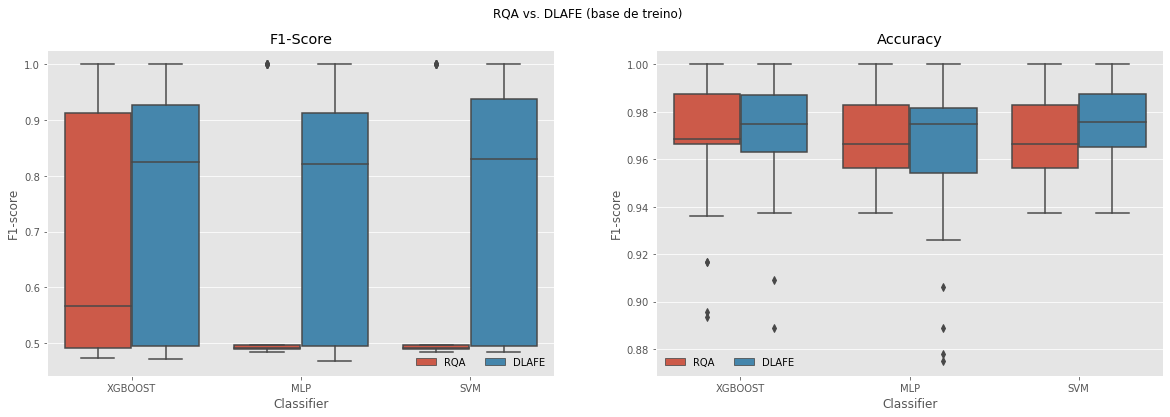

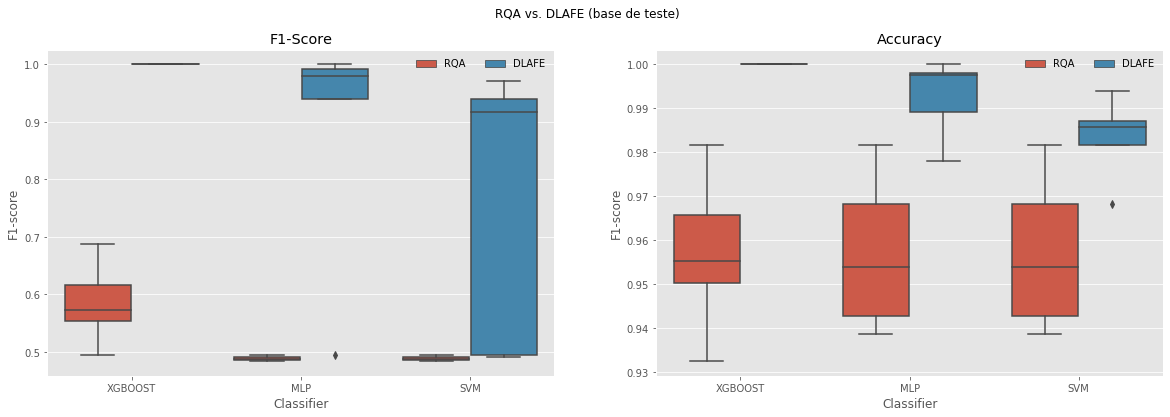

In [45]:
for b in ['treino','teste']:
    df_ = df.query(f"base == '{b}'").reset_index()

    df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
    df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 
    
#     fig = plt.figure(figsize=(20,8));
#     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
#     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
#     plt.show();
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    sns.boxplot(x="classifier", y="f1",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], ax=ax1)
    ax1.set(xlabel='Classifier', ylabel='F1-score', title='F1-Score')
    ax1.legend(frameon=False, loc='best', ncol=2);    
    
    sns.boxplot(x="classifier", y="acc",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], ax=ax2)
    ax2.set(xlabel='Classifier', ylabel='F1-score', title='Accuracy')
    ax2.legend(frameon=False, loc='best', ncol=2);  
    
    plt.suptitle(f"RQA vs. DLAFE (base de {b})");
    plt.show();

    # fig.savefig(
    #     'D:/Users/diego/MEGA/Pesquisa/Papers/IEEE PES GM 2021/destination_path.jpg', 
    #     format='jpg',
    #     dpi=300,
    #     bbox_inches='tight', pad_inches=0

    # )

## Análise Por Aparelho

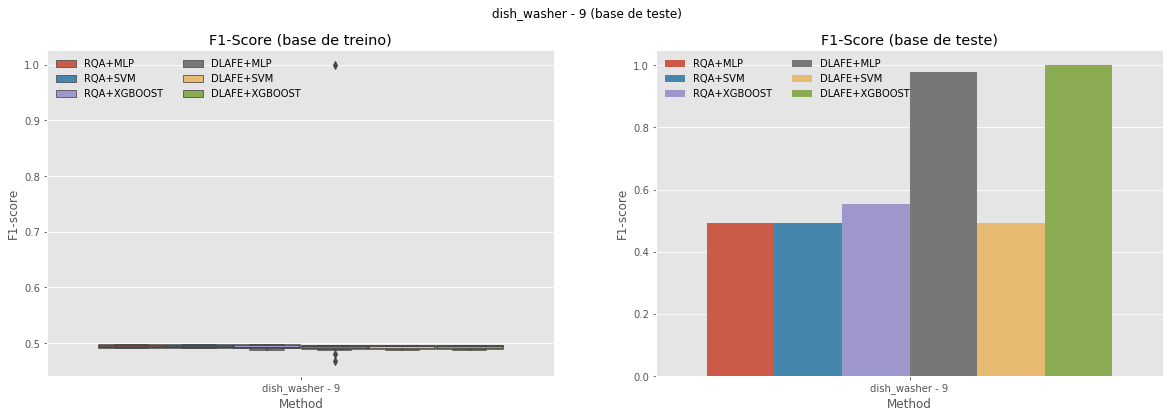

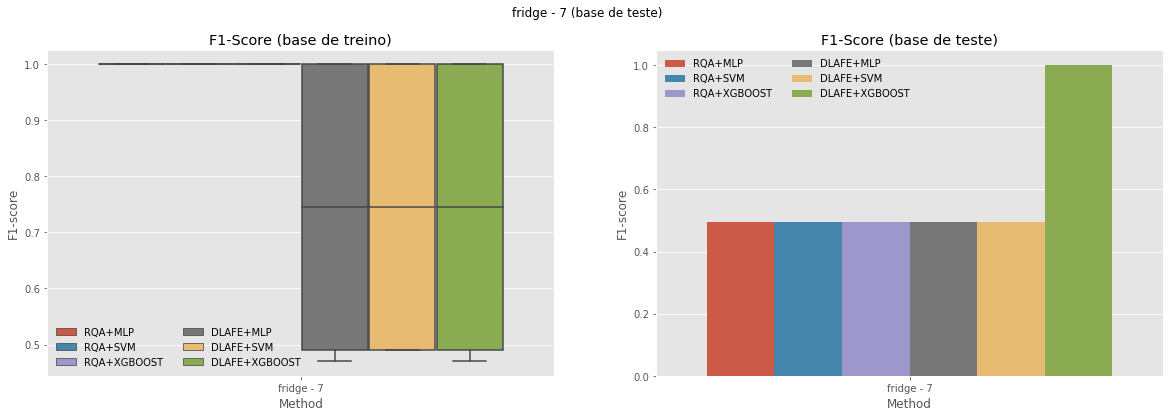

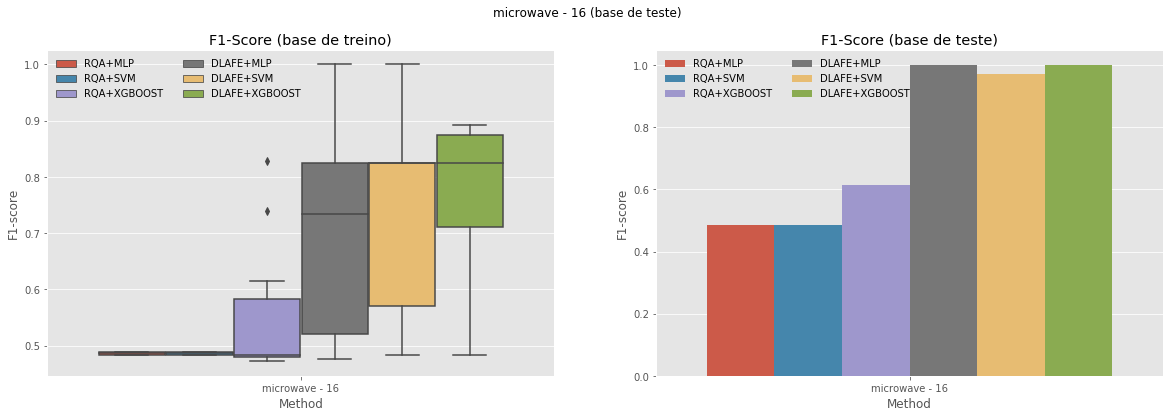

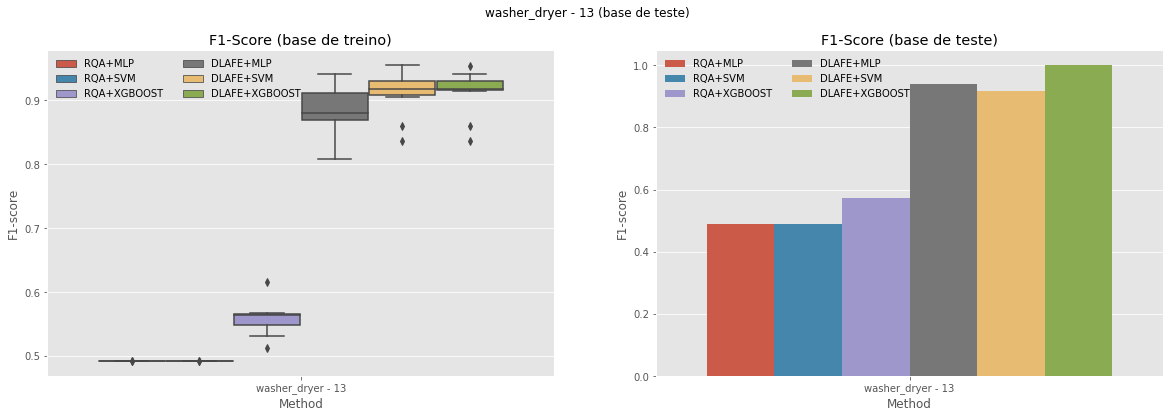

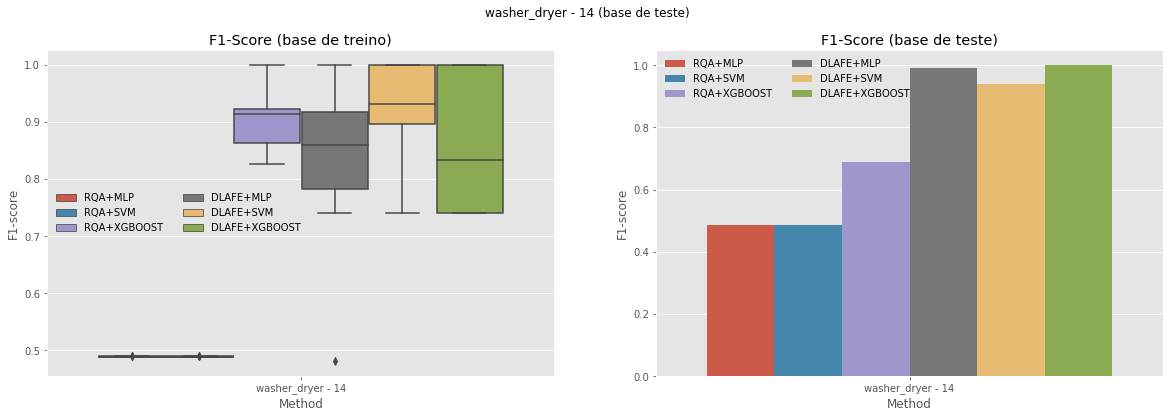

In [68]:
for a in df['appliance'].unique():
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    for i, b in enumerate(['treino','teste']):
        
        df_ = df.query(f"appliance == '{a}' and base == '{b}'").reset_index()

        df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
        df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 

    #     fig = plt.figure(figsize=(20,8));
    #     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
    #     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
    #     plt.show();

        if b == 'treino':
            sns.boxplot(x="appliance", y="f1",
                        hue="method", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=axes[i])
        else:
            sns.barplot(x="appliance", y="f1",
                        hue="method", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=axes[i])

        axes[i].set(xlabel='Method', ylabel='F1-score', title=f'F1-Score (base de {b})')
        axes[i].legend(frameon=False, loc='best', ncol=2); 

            #         sns.boxplot(x="appliance", y="acc",
#                     hue="method", #order=["XGBOOST","MLP","SVM"],
#                     data=df_[df_['classifier']!='CNN'], 
#                     ax=axes[1])
#         axes[1].set(xlabel='Appliance', ylabel='F1-score', title='Accuracy')
#         axes[1].legend(frameon=False, loc='best', ncol=2);  

        plt.suptitle(f"{a} (base de {b})");
    plt.show();

In [ ]:


# Conclusões

* Ficou evidente que o método 2 (baseado em extração automática de atributos do RP via Deep Learning), adotando o classificador XGBOOST, forneceu o melhor desempenho global;
    - Analisando o TOP-5, 3 dos melhores resultados foram obtidos através dos atributos extraídos automaticamente via DL (classificadores XGBOOST, MLP e SVM - nesta ordem);
    - Denota-se que o uso de modelos de Deep Learning pré-treinado é uma estratégia promissora para este problema;
    - Vale avaliar mais detalhadamente esta abordagem:
        + Outras arquiteturas de DL para extração de características;
        + Ajuste de hiperparâmetros, tanto do extrator (eg.: pooling máximo para extração de características) quanto do classificador e gráfico de recorrência*;
    - Fine tuning no domínio do problema:
        + Pré-treinar o extrator com dados de outros aparelhos/residências;
       

* O método 3 (RP+CNN) se mostra promissor, mas tem seu desempenho comprometido em grande parte pelo pequeno número de amostras do dataset.

# Fim.

In [6]:
%load_ext watermark

In [7]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Diego Luiz Cavalca 
last updated: Sat Sep 05 2020 17:09:35 Hora oficial do Brasil 

CPython 3.7.8
IPython 7.17.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 5725caa95e9d7f4b19a57eff5b998f1738bc40b4
